## **Exploratory analysis and prediction on the "TMDB 5000 Movie Dataset" dataset**

***Authors: Bava Flavio 4836427 , Ciarlo Francesco 4640121, Oldrini Edoardo 4055097***

The following data analysis aims to study an approach for the production of a movie.<br><br>
This file is divided like so:
* Dataset checking and preparation
* Initial exploration of the dataset
* Proposal predictive models based on previous observations

**Importing libraries and dataset**

In [130]:
#libraries
import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.graph_objs as go
import plotly.offline as py
from ast import literal_eval
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings 

#initial settings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_columns',10000)

In [131]:
Movies = pd.read_csv('input/tmdb_5000_movies.csv')

### **Exploratory analysis of the dataset**

#### First of all, we intend to have an overall idea of the available dataset, in particular the dimensions of the dataset and the structure of the entries:

In [132]:
print("Dataset has {} rows and {} columns".format(Movies.shape[0],Movies.shape[1]))

Dataset has 4803 rows and 20 columns


In [133]:
Movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


Columns like homepage, spoken_languages and title are usless or redondant, hence we proceed to drop them

In [134]:
Movies.drop(['homepage','spoken_languages','title'],inplace=True,axis='columns')

#### We check if the types of datas are coherent

In [135]:
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   production_countries  4803 non-null   object 
 10  release_date          4802 non-null   object 
 11  revenue               4803 non-null   int64  
 12  runtime               4801 non-null   float64
 13  status                4803 non-null   object 
 14  tagline               3959 non-null   object 
 15  vote_average         

Data types are coherent with the information they represent

#### We check if any null values are in the dataset

In [136]:
Movies.isnull().sum()

budget                    0
genres                    0
id                        0
keywords                  0
original_language         0
original_title            0
overview                  3
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
status                    0
tagline                 844
vote_average              0
vote_count                0
dtype: int64

The column tagline has a huge number of null values, we will manage them when we'll work on this feature.

#### Some columns are in Json format, hence we proceed to convert them to lists

Definition of auxiliary funcitons

In [137]:
def get_name(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        return names
    return []

def get_ISO(x):
    if isinstance(x, list):
        isos = [i['iso_3166_1'] for i in x]
        return isos
    return []

Conversion

In [138]:
feat_to_manage = ['genres','keywords','production_countries','production_companies']
for f in feat_to_manage:
    Movies[f] = Movies[f].apply(literal_eval)

In [139]:
#Turn genres into list
Movies['genres'] = Movies['genres'].apply(get_name)
#Turn prod_countries into list
Movies['production_countries'] = Movies['production_countries'].apply(get_ISO)
#Turn prod_companies into list
Movies['production_companies'] = Movies['production_companies'].apply(get_name)
#Turn keywords into list
Movies['keywords'] = Movies['keywords'].apply(get_name)

#### Some movies are in post producion or are still just rumored but we want to work only on released movies

In [140]:
Movies = Movies.query('status == "Released"')

## **Dataset Analysis**

### Numerical features

#### Budget

##### Let's have a first look to the budget feature

In [141]:
Movies['budget'].describe()

count    4.795000e+03
mean     2.909267e+07
std      4.073962e+07
min      0.000000e+00
25%      8.000000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

The minimum value of the budget feature is 0. We must discard movies with a non acceptable budget, hence we keep only movie budgets with greater than 10 k, any value < 10 k is interpreted as wrong hence put o nan

In [142]:
for row in Movies.index:
    if Movies.loc[row,'budget'] < 10000:
        Movies.loc[row,'budget'] = np.nan
        
Movies['budget'].describe()

count    3.728000e+03
mean     3.741935e+07
std      4.269910e+07
min      1.000000e+04
25%      8.975000e+06
50%      2.400000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

##### Now the budget are acceotable, we divide movies in three classes by budget:
- Low: 1.000000e+04 <= x <= 8.975000e+06 (class 1) 
- Medium: 8.975000e+06 < x <= 5.000000e+07 (class 2)
- High: 5.000000e+07 < x <= 3.800000e+08 (class 3)

In [143]:
bins = [1.000000e+04, 8.975000e+06, 5.000000e+07, 3.800000e+08]
labels=[1,2,3]
Movies['budget_class'] = pd.cut(Movies['budget'],bins=bins,labels=labels)


let's print the count of movies for each budget class

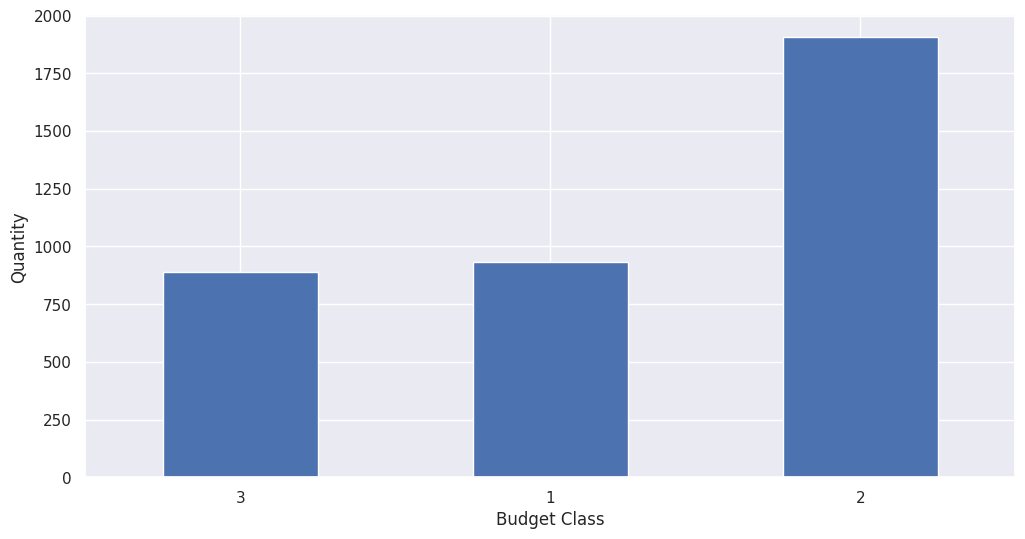

In [144]:
ax = Movies['budget_class'].value_counts().sort_values(ascending=True).plot(kind='bar')
ax.set_xlabel("Budget Class")
ax.set_ylabel("Quantity")
plt.xticks(rotation="horizontal")
plt.show()

The graph is coherent with the divisions we made

##### Let's check the distribution of budgets:

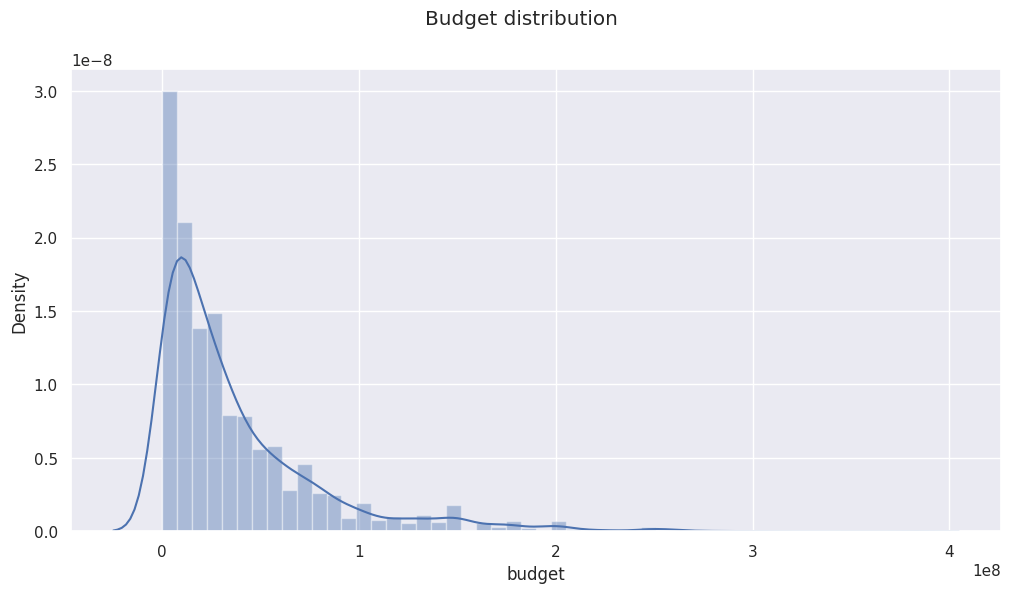

Budget skewness:  2.218841914564844


In [145]:

sns.distplot(Movies['budget'])
sns.set(rc={'figure.figsize':(12,6)})
plt.suptitle('Budget distribution')
plt.show()

print("Budget skewness: ",Movies['budget'].skew())


The distribution is skewed, this could be a problem for the machine learning algorithm, hance we try to adjust the skewness of the distribution

In [146]:
from sklearn.preprocessing import PowerTransformer

In [147]:
pt = PowerTransformer(method='box-cox',standardize=False)
Movies['transf_budget'] = pt.fit_transform(Movies[['budget']])

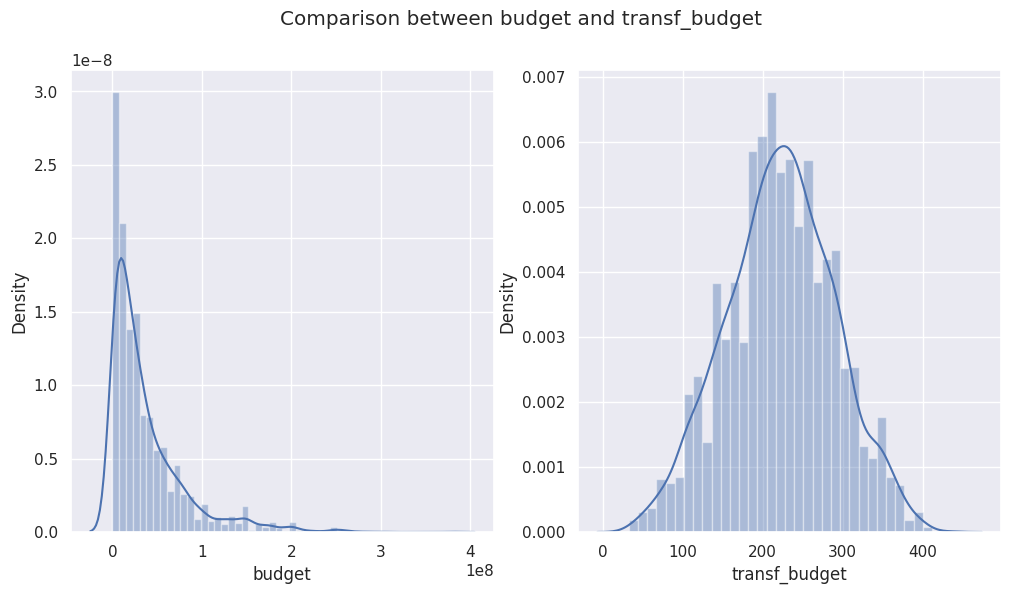

In [148]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.distplot(Movies['budget'],ax=ax1)
sns.distplot(Movies['transf_budget'],ax=ax2)
fig.suptitle("Comparison between budget and transf_budget")
plt.show()




In [149]:
print("Skewness before log : {} and Skewness after log : {}".format(Movies['budget'].skew(),Movies['transf_budget'].skew()))

Skewness before log : 2.218841914564844 and Skewness after log : -0.038231651583918155


## Revenues ##

In [150]:
print('Movies with 0$ revenues: ',Movies[Movies['revenue'] == 0].shape[0])

Movies with 0$ revenues:  1420


We also set these to Nan

In [151]:
for row in Movies.index:
    if (Movies.loc[row, 'revenue'] == 0):
        Movies.loc[row, 'revenue'] = np.nan

In [152]:
Movies['revenue'].isna().sum()

1420

In [153]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox',standardize=False)

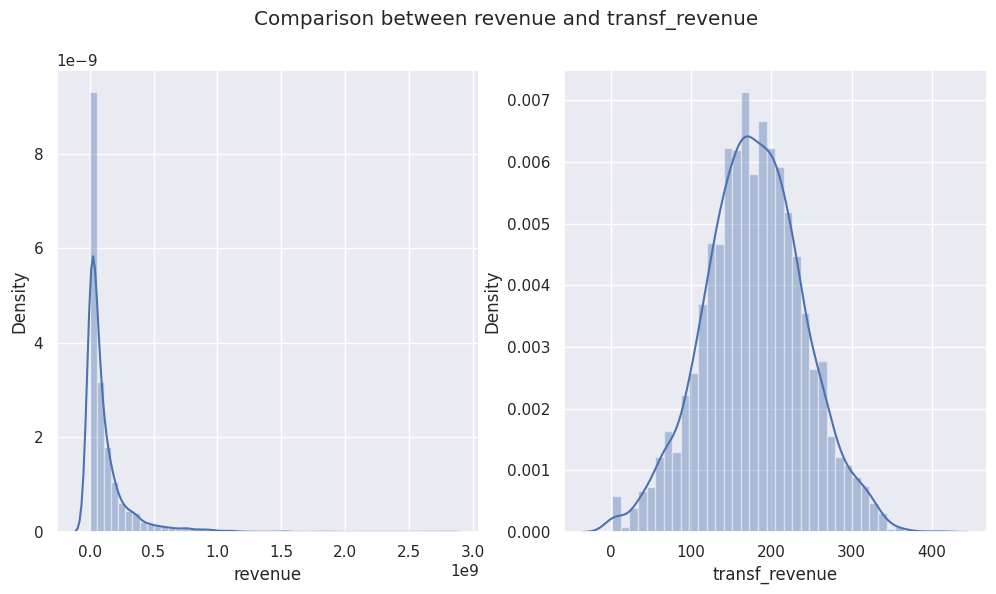

In [154]:
Movies['transf_revenue'] = pt.fit_transform(Movies[['revenue']])
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

sns.distplot(Movies['revenue'],ax=ax1)
sns.distplot(Movies['transf_revenue'],ax=ax2)
fig.suptitle("Comparison between revenue and transf_revenue")
plt.show()

In [155]:
print("Skewness before log : {} and Skewness after log : {}".format(Movies['revenue'].skew(),Movies['transf_revenue'].skew()))

Skewness before log : 3.884930617583634 and Skewness after log : -0.01712489323004914


## Score ##

We want to eliminate those films that have a low percentage of vote_count(votes given), because it would create imbalances,
given that a film voted 8, but by 5 people, is not reliable

In [156]:
#TODO: potremmo anche fare questo lavoro sul dataset di partenza aggiungendo una colonna, metà avranno nan
C = Movies['vote_average'].mean()
C
m = Movies['vote_count'].quantile(0.5)

for i in Movies.index:
    if Movies.loc[i,'vote_count'] <= m:
        Movies.loc[i,'vote_count'] = np.nan
    else:
        pass

    
q_movies = Movies[['id','vote_count','vote_average']]

We consider it important that the average vote is weighted with the number of votes that generate it, to do this we use the formula recommended by the IMBD site and remove the two columns vote_average and vote_count to merge them into one that combines them

In [157]:
#Weighted Rating
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [158]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

q_movies.drop(['vote_average','vote_count'],inplace=True,axis='columns')

#Dataframe merge, now Movies also has Score column"
Movies = pd.merge(Movies,q_movies,on='id',how='inner')

Movies.shape

(4795, 21)

We have eliminated some films (in q_movies), those with too few votes to be taken into consideration with regard to the received vote and then we have combined the two dataframes, so now Movies also has the score column

## Profits ##

We measure the revenues against the budget through a function, and add a new column called 'profit_perc' containing the results

In [159]:
def calculate_profit_perc(x):
    if (x.revenue>0) and (x.budget>0):
        return ((x.revenue-x.budget)/x.budget)*100
    

In [160]:
Movies = Movies.assign(profit_perc = lambda x: x.budget)
for row in Movies.index:
    Movies.loc[row,'profit_perc'] =  calculate_profit_perc(Movies.loc[row])

We define a function which, given a genre, calculates the average of the profits of the films that contain it

In [161]:
temp = Movies
temp.dropna(axis=0,inplace=True)

In [162]:
#How many movies are there by genre with profit other than Nan
def films_per_genres(genre):
    count = 0
    for row in temp.index:
        if (genre in temp.loc[row, 'genres'] and (temp.loc[row,'profit_perc'] != np.nan)):
            count+=1
    return count


#Profits by genre
def genre_average_profits(genre):
    sum = 0
    count = 0
    for row in temp.index:
        if (genre in temp.loc[row, 'genres'] and (temp.loc[row,'profit_perc'] != np.nan)):
            sum += temp.loc[row, 'profit_perc']
            count+=1
    return sum/count



In [163]:
genres=[]
for row in temp.index:
    _gen = temp.loc[row,'genres']
    for g in _gen:
        if g not in genres:
            genres.append(g)

profits=[]
for g in genres:
    profits.append(genre_average_profits(g))
            
print("Profits for each genre:")
for i in range(0,len(genres)):
    print('\t',genres[i], " has a mean profit of ", profits[i])

Profits for each genre:
	 Action  has a mean profit of  304.0197925073328
	 Adventure  has a mean profit of  410.4735995190337
	 Fantasy  has a mean profit of  333.67295828967104
	 Science Fiction  has a mean profit of  357.4043673286655
	 Crime  has a mean profit of  282.76597145297075
	 Drama  has a mean profit of  569.8323474101483
	 Thriller  has a mean profit of  561.0186645149466
	 Animation  has a mean profit of  649.5884284948968
	 Family  has a mean profit of  540.9222601790862
	 Western  has a mean profit of  637.414451302206
	 Comedy  has a mean profit of  504.77933325142254
	 Romance  has a mean profit of  536.4716202005993
	 Horror  has a mean profit of  8295.371058234967
	 Mystery  has a mean profit of  9041.087375998894
	 History  has a mean profit of  301.421669610385
	 War  has a mean profit of  468.05337132789015
	 Music  has a mean profit of  813.5654206579787
	 Documentary  has a mean profit of  6119.964841509324


We can observe how some films have a very high profit, this is given by the fact that for example Horror films have earned a lot and there are few within the dataset, so let's see the cardinalities of each genre

In [164]:
films = []
for el in genres:
    films.append(films_per_genres(el))
    
print("Genres in the dataframe are:")
for genre,film in zip(genres,films):
    print(genre,film)

Genres in the dataframe are:
Action 688
Adventure 519
Fantasy 277
Science Fiction 339
Crime 373
Drama 835
Thriller 687
Animation 143
Family 258
Western 31
Comedy 704
Romance 323
Horror 241
Mystery 195
History 77
War 73
Music 50
Documentary 9


Documentaries, for example, are very few compared to the total of films and have a percentage profit of around 6119, therefore, for the reason mentioned above, they greatly unbalance the accounts. We can afford to exclude them, since there are only 9

In [165]:
genres.remove(genres[-1])
profits.remove(profits[-1])

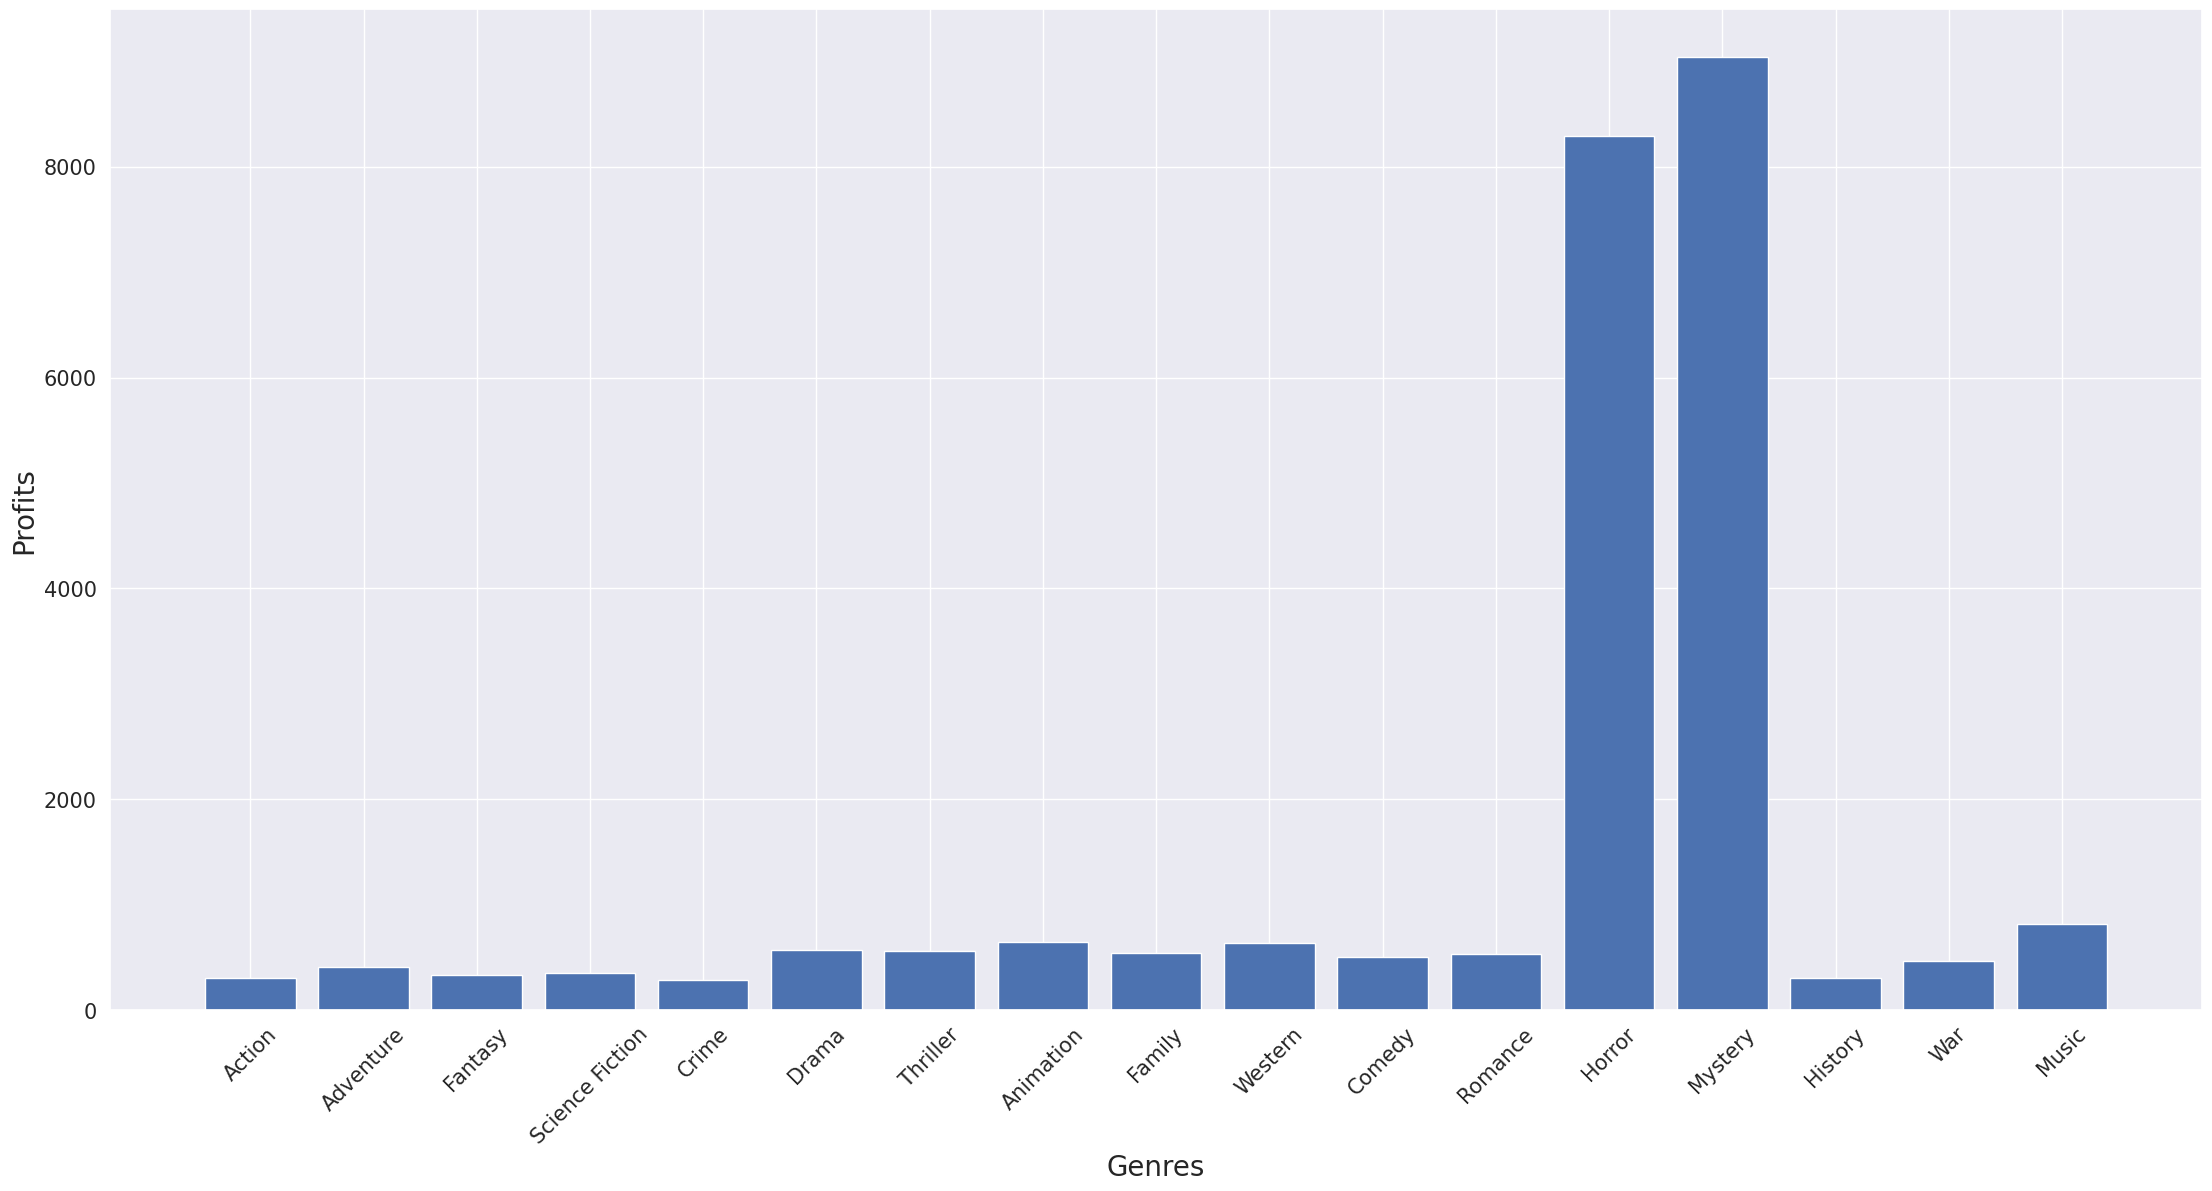

In [166]:
fig, ax = plt.subplots()
ax.bar(genres,profits)
fig.set_figwidth(27)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genres", fontsize=20)
plt.ylabel("Profits", fontsize=20)
plt.show()

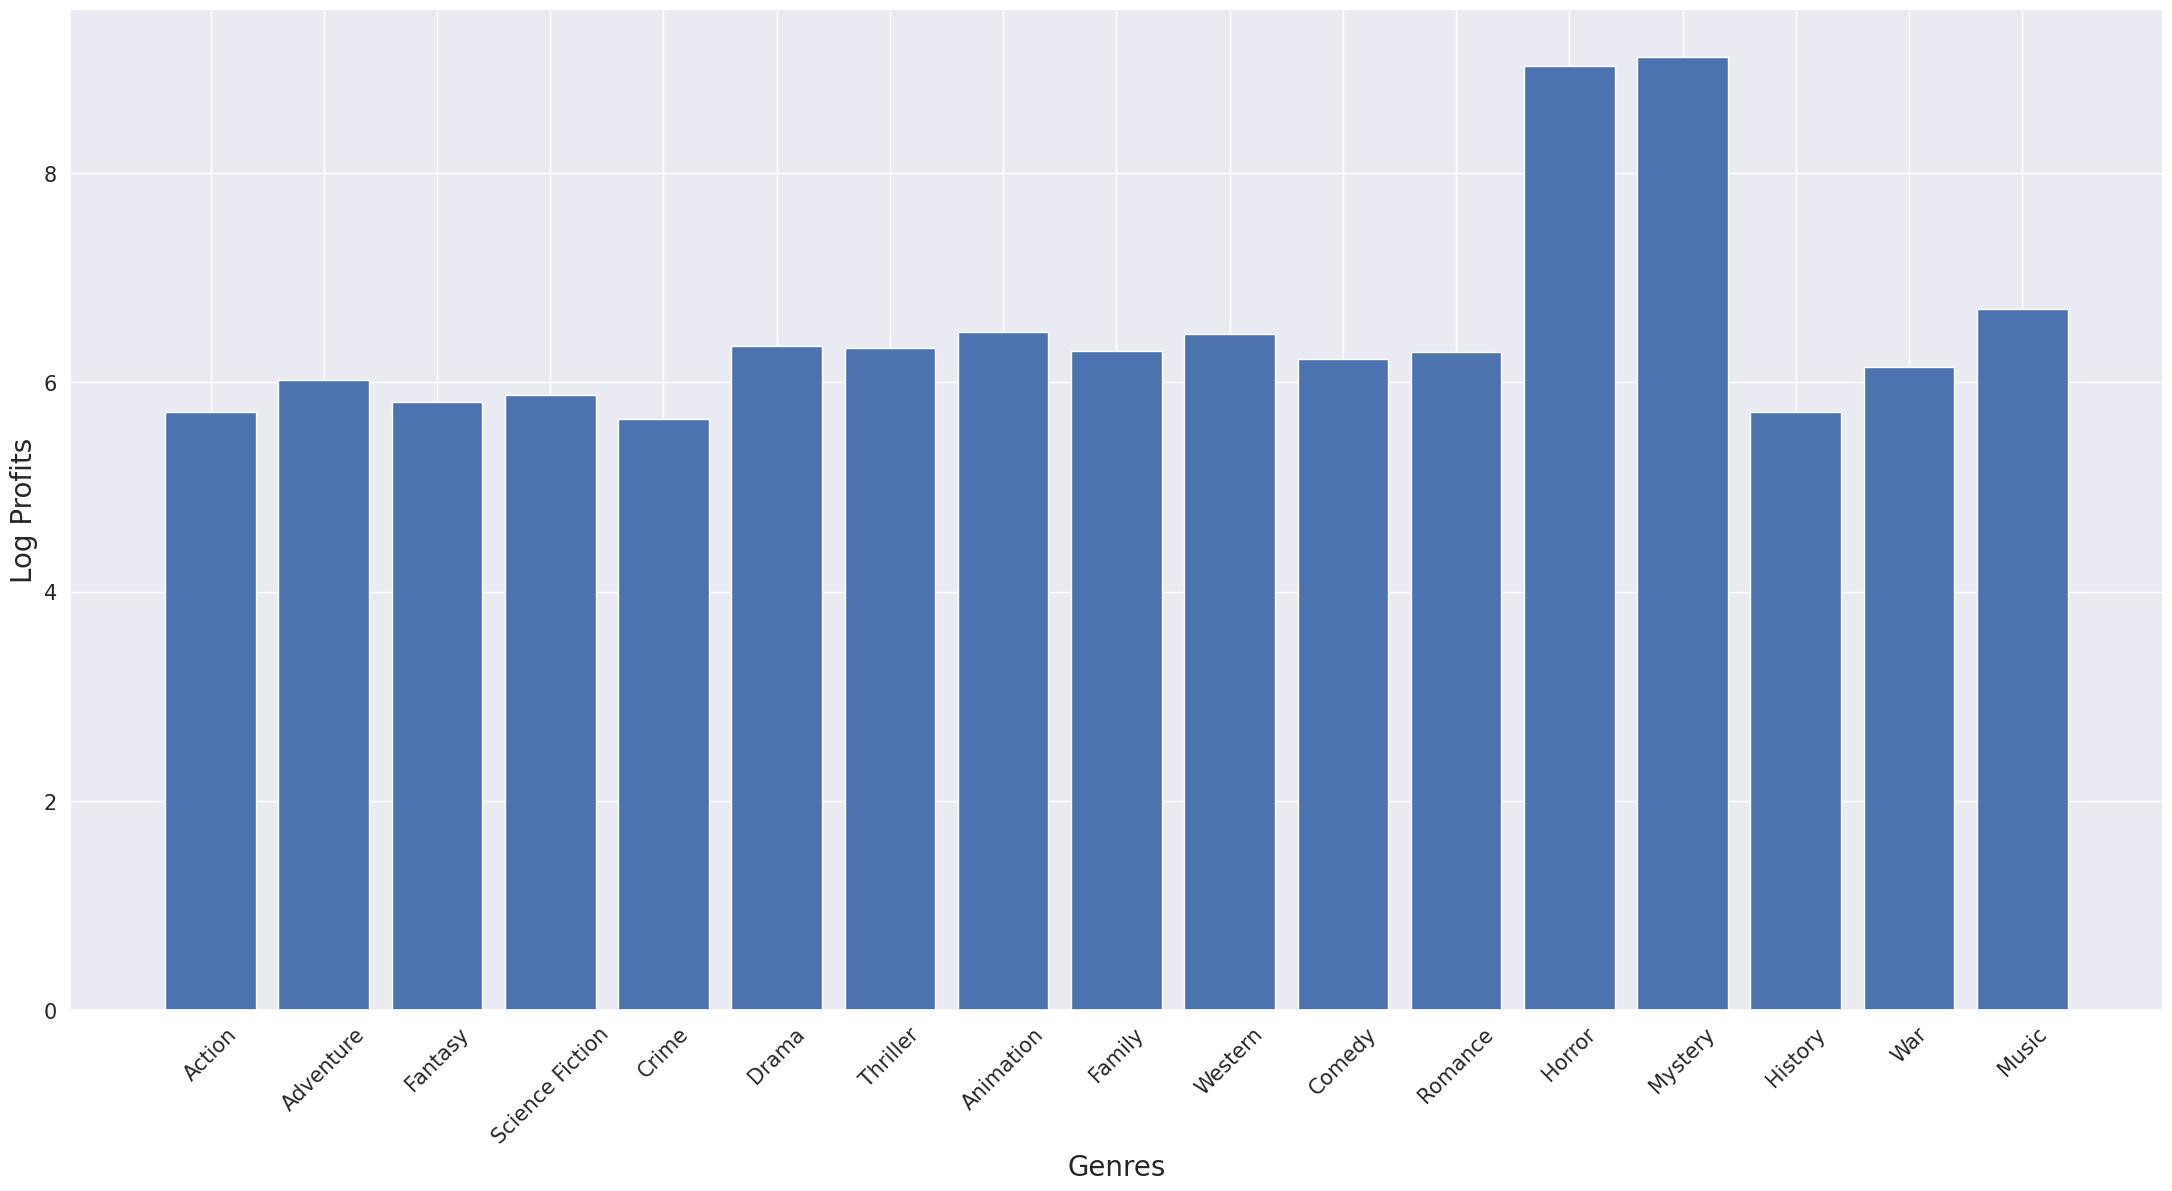

In [167]:
log_profit = np.log1p(profits)
fig, ax = plt.subplots()
ax.bar(genres,log_profit)
fig.set_figwidth(27)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genres", fontsize=20)
plt.ylabel("Log Profits", fontsize=20)
plt.show()

## Keywords ##

Let's see what are the most frequent words present among the keywords

[nltk_data] Downloading package stopwords to /home/flenz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/flenz/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


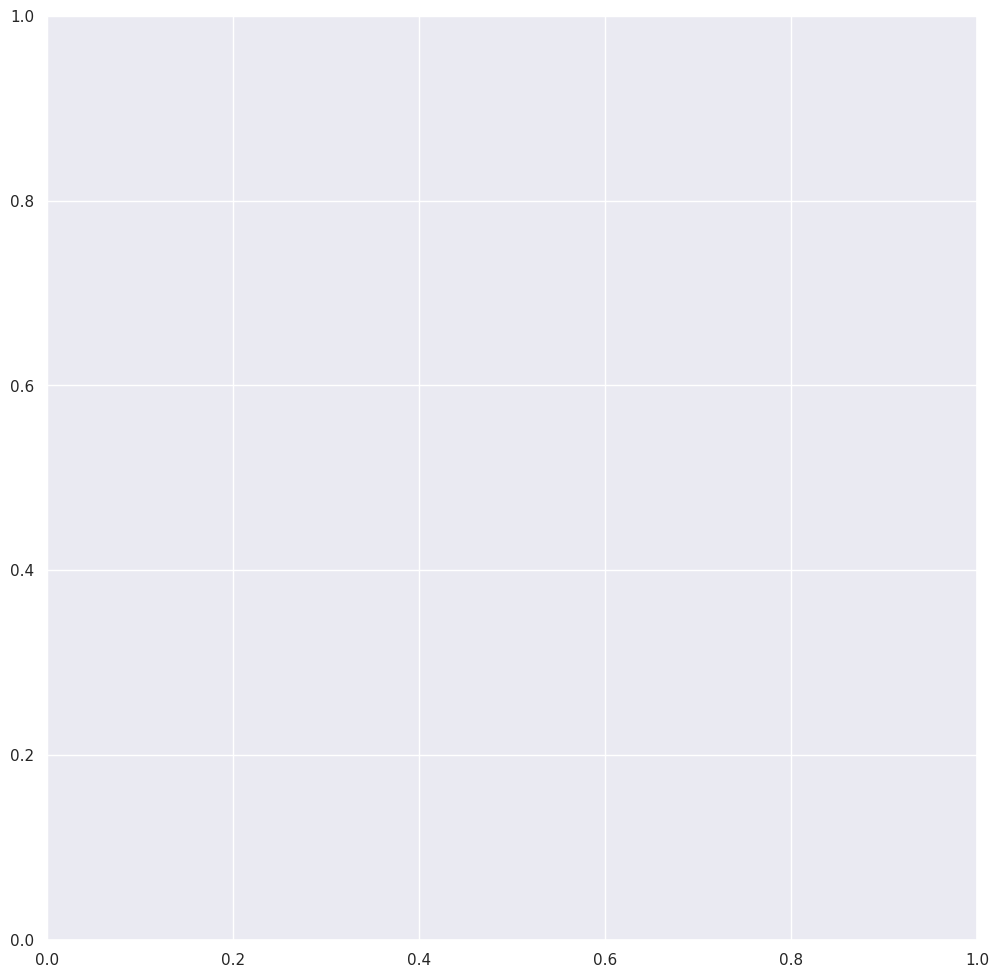

In [170]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")



plt.subplots(figsize=(12,12))
stop_words=set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

Movies['keywords'].dropna(inplace=True)
keywords_converted = Movies['keywords'].astype(str)
words=keywords_converted.apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000,stopwords=STOPWORDS, max_font_size= 60,width=1000,height=600)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()


## Release Date ##

In [171]:
#Convert the Relase date to datetime format
temp['release_date'] = pd.to_datetime(temp['release_date'])
temp['release_year'] = temp['release_date'].dt.year
temp['release_month'] = temp['release_date'].dt.month
temp['release_day'] = temp['release_date'].dt.dayofweek

In [172]:
temp['decades'] = temp['release_date'].apply(lambda x : (x.year // 10)*10)

Quantity of films released during months of the year

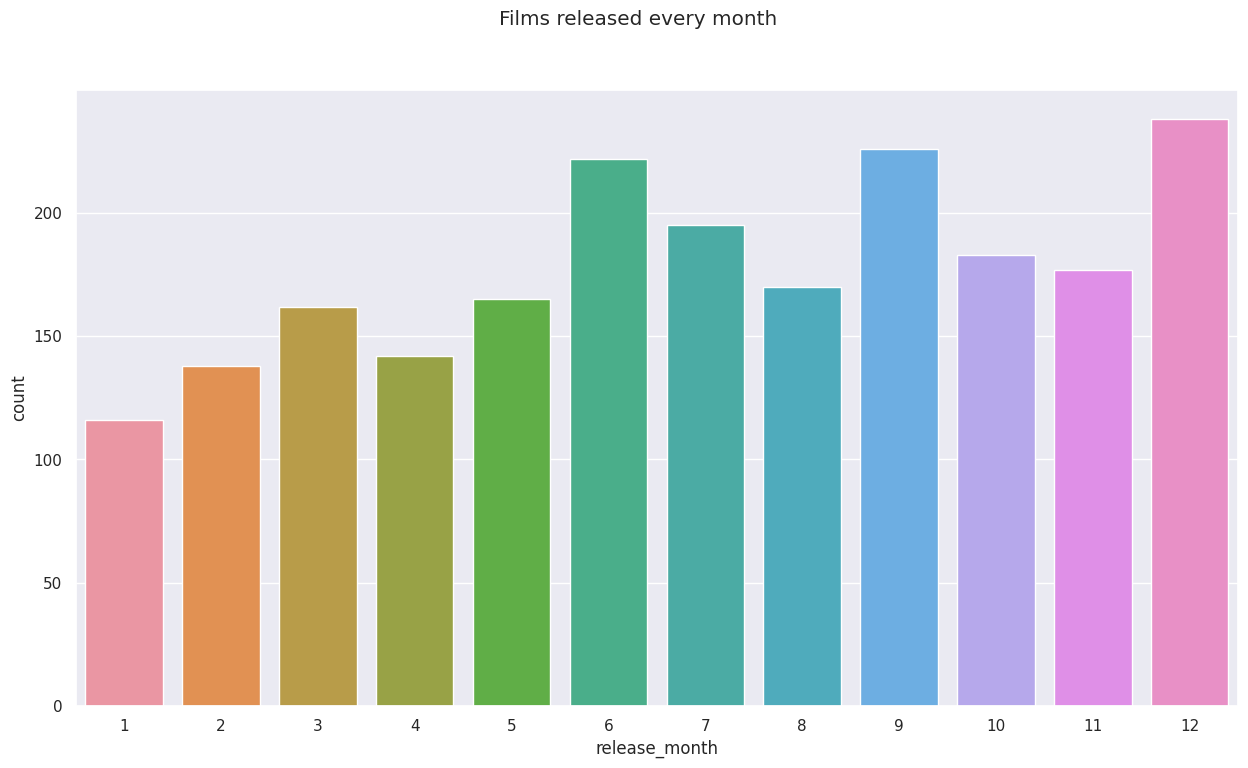

In [173]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x='release_month',data=temp)
plt.suptitle("Films released every month")
plt.show()

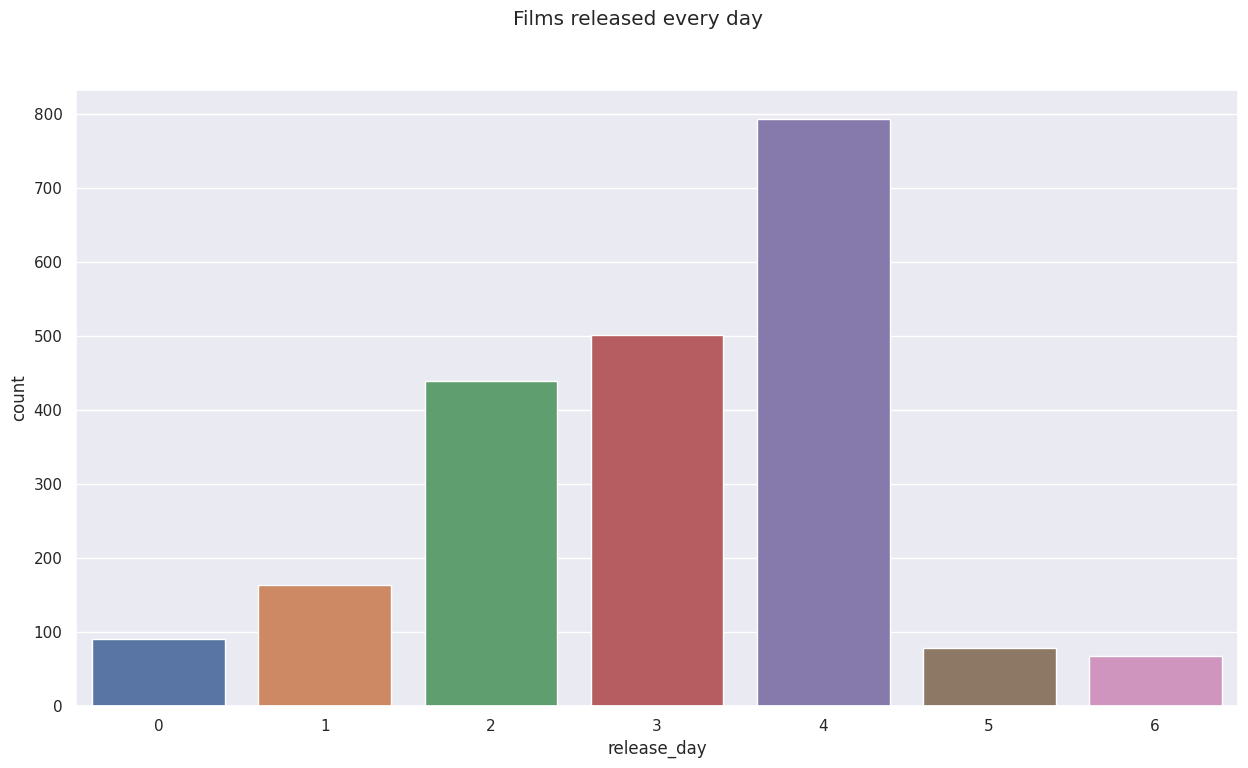

In [174]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x='release_day',data=temp)
plt.suptitle("Films released every day")
plt.show()

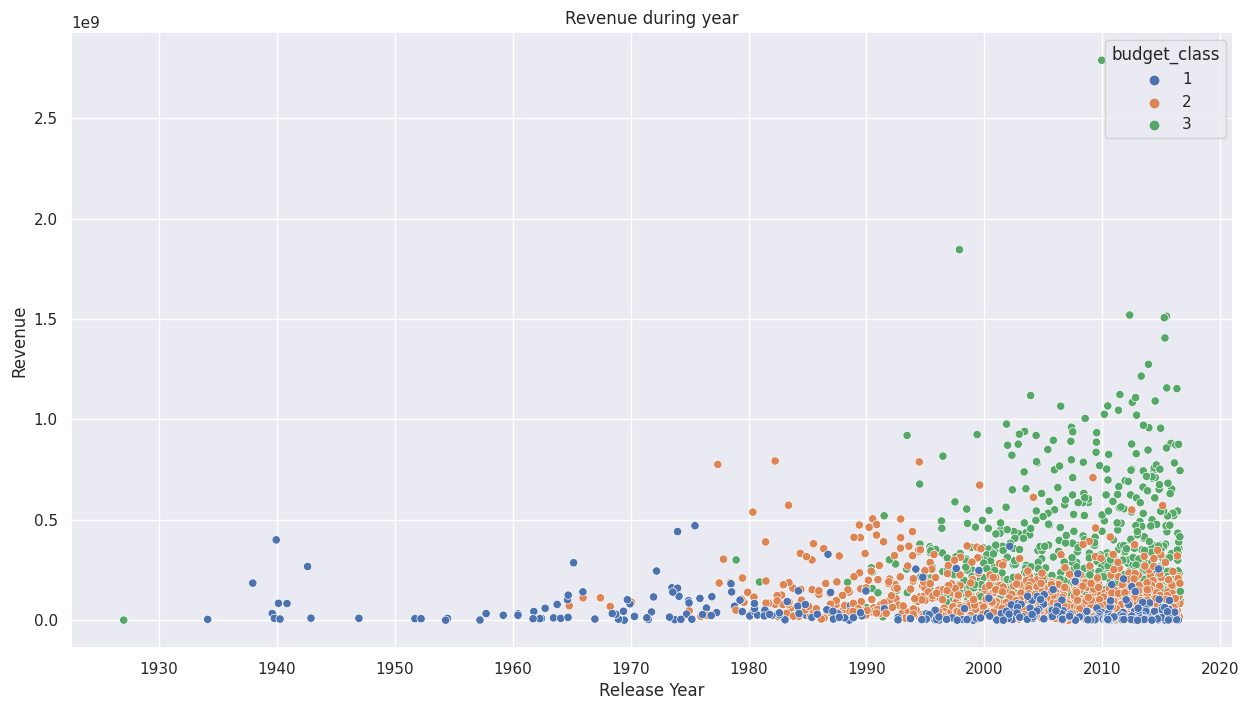

In [175]:
ax = sns.scatterplot(x="release_date",y="revenue",data=temp,hue="budget_class")
sns.set(rc = {'figure.figsize':(6,6)})
ax.set_title("Revenue during year")
ax.set_xlabel("Release Year")
ax.set_ylabel("Revenue")
plt.show()

The graph above shows how revenues have increased over time, as have budgets invested

In [176]:
d2 = temp.groupby(['release_month'])['revenue'].mean()
data = [go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y')]
layout = go.Layout(dict(title = "Average revenue per month",
                  xaxis = dict(title = 'Month'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [177]:
d2 = temp.groupby(['release_day'])['revenue'].mean()
data = [go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y')]
layout = go.Layout(dict(title = "Average revenue per Day",
                  xaxis = dict(title = 'Day'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

## Popularity ##

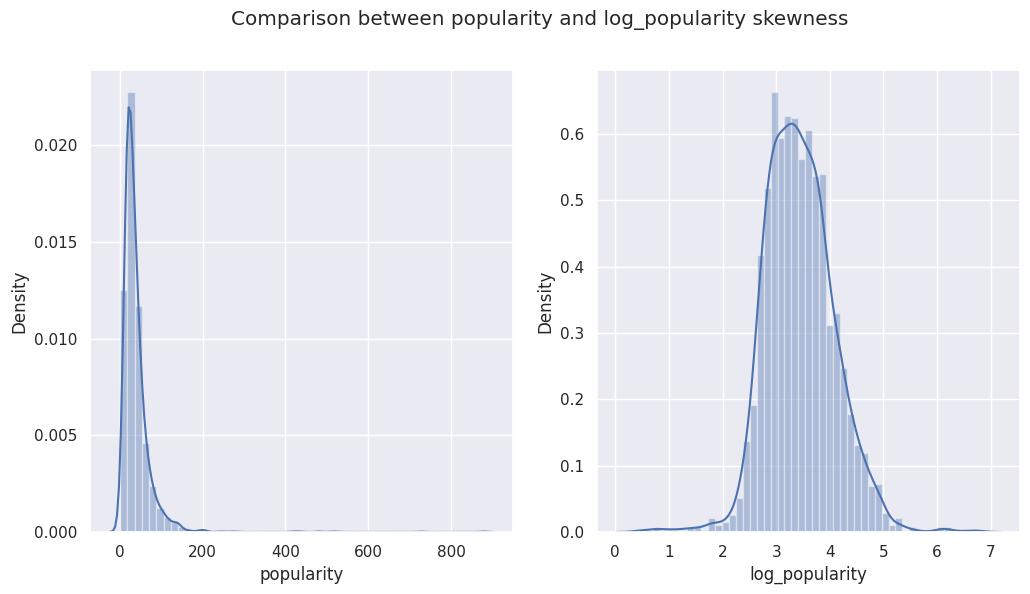

In [178]:
temp['log_popularity'] = np.log(temp['popularity'])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

sns.distplot(temp['popularity'],ax=ax1)
sns.distplot(temp['log_popularity'],ax=ax2)

fig.suptitle("Comparison between popularity and log_popularity skewness")

plt.show()


In [179]:
print("Skewness before log : {} and Skewness after log : {}".format(temp['popularity'].skew(),temp['log_popularity'].skew()))

Skewness before log : 9.382230160157636 and Skewness after log : 0.27324869836877314


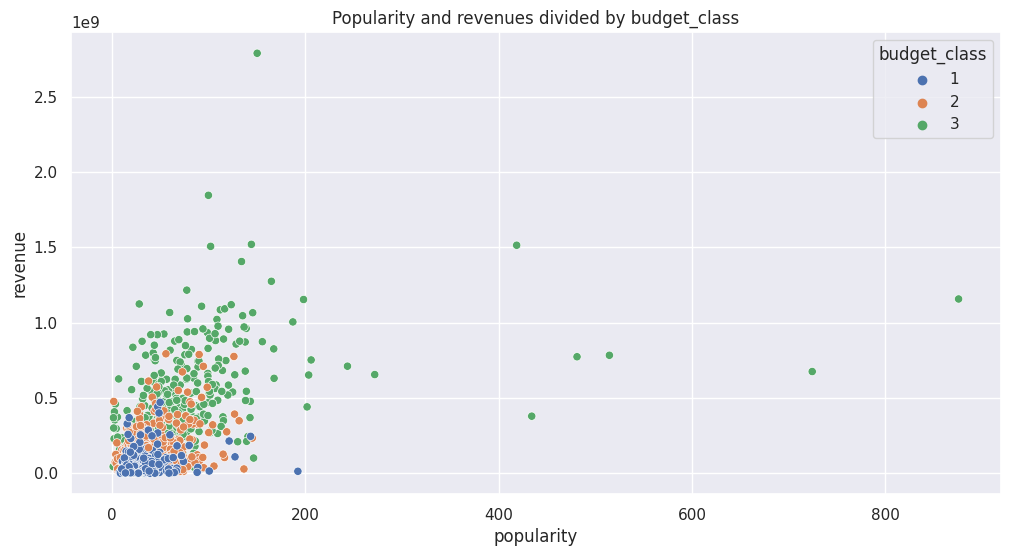

In [180]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.scatterplot(x='popularity',y='revenue',data=temp,hue="budget_class")
ax.set_title("Popularity and revenues divided by budget_class")
plt.show()

# Cast & Directors #

In [181]:
temp.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime', 'status',
       'tagline', 'vote_average', 'vote_count', 'budget_class',
       'transf_budget', 'transf_revenue', 'score', 'profit_perc',
       'release_year', 'release_month', 'release_day', 'decades',
       'log_popularity'],
      dtype='object')

In [182]:
cast = pd.read_csv("input/tmdb_5000_credits.csv")

In [183]:
feat_to_manage = ['cast','crew']
for f in feat_to_manage:
    cast[f] = cast[f].apply(literal_eval)

#Two functions that convert directors and actors from json to list-str
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_actors(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        
        return names
    return []

In [184]:
#Create two new column correctly formatted
cast['director'] = cast['crew'].apply(get_director)
cast['actors'] = cast['cast'].apply(get_actors)

In [185]:
#Drop old columns
cast.drop('cast',inplace=True,axis=1)
cast.drop('crew',inplace=True,axis=1)
cast.drop('title',inplace=True,axis=1)

In [186]:
#rename Movie_id to id, preparing for the merge
cast = cast.rename(columns={'movie_id': 'id'})

#Merge two dataframe Movies,cast
full_df = pd.merge(temp,cast,on="id",how="inner")
recommend_df = full_df.copy()

## Actors ##

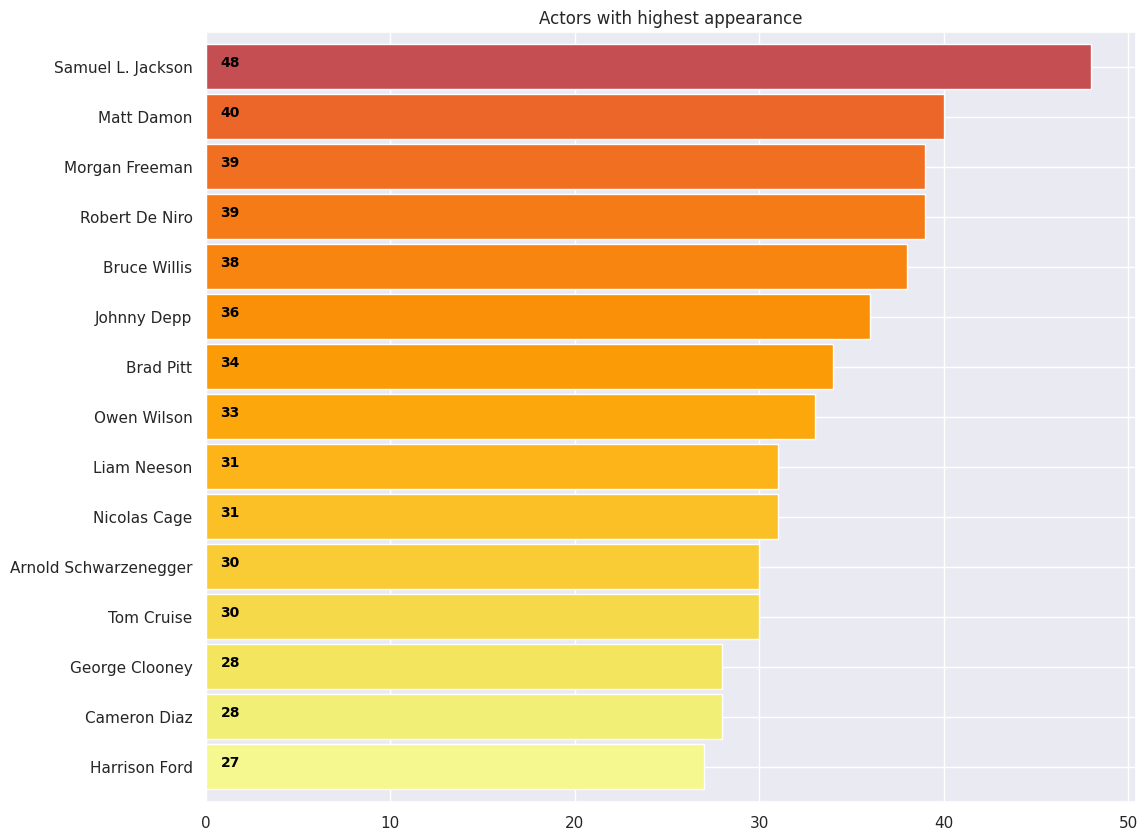

In [187]:
actors=[]


for i in full_df['actors']:
    actors.extend(i)

actors = list(filter(None, actors))


plt.subplots(figsize=(12,10))
ax=pd.Series(actors).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(actors).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='black',weight='bold')

plt.title('Actors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()

## Directors ##

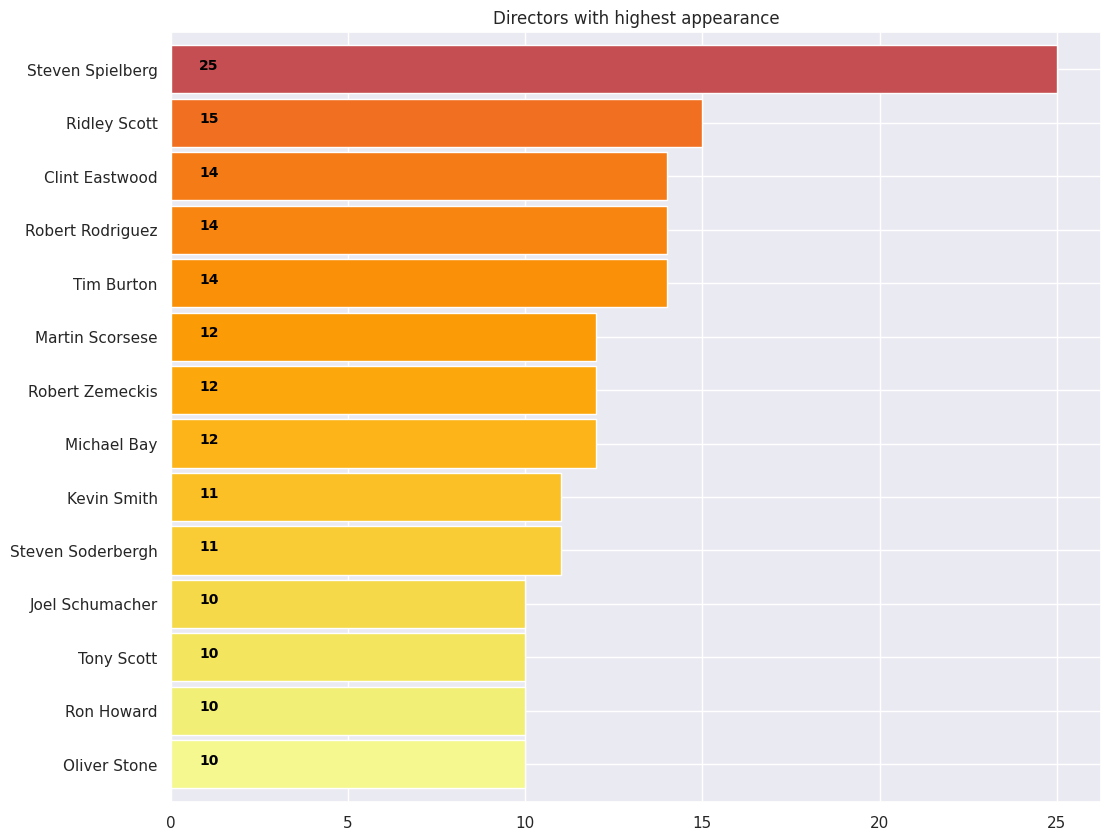

In [188]:
directors=[]


for i in full_df['director']:
    directors.append(i)

directors = list(filter(None, directors))


plt.subplots(figsize=(12,10))
ax=pd.Series(directors).value_counts()[:14].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(directors).value_counts()[:14].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='black',weight='bold')

plt.title('Directors with highest appearance')
ax.patches[13].set_facecolor('r')
plt.show()

We calculate the average Score for the most present directors (>= 10)

In [189]:
#Filter the directors with made films >= 10,then calculate the mean scores
director_group = full_df.groupby('director').filter(lambda x : len(x) >= 10)
mean_scores = director_group.groupby('director')['score'].mean().sort_values(ascending=False).reset_index(name="score")

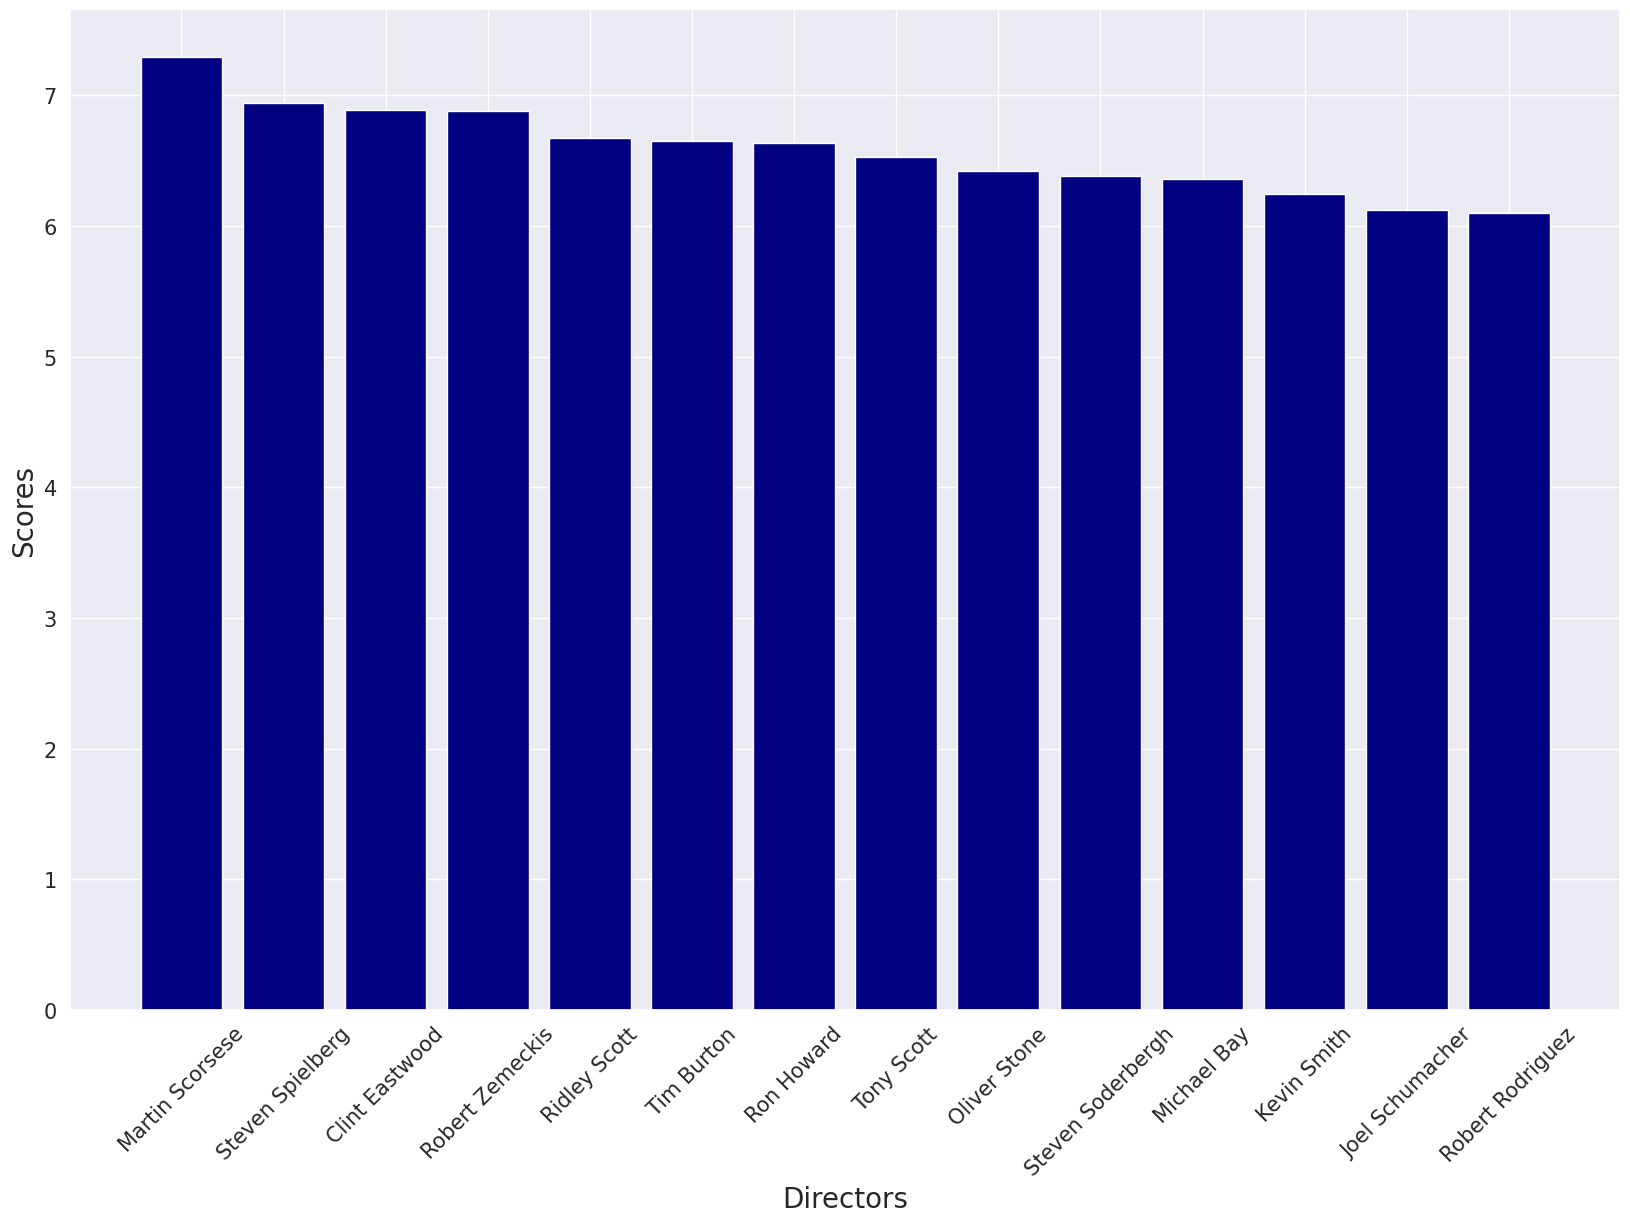

In [190]:
fig, ax = plt.subplots()
ax.bar(mean_scores['director'],mean_scores['score'],color='navy')
fig.set_figwidth(20)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Directors", fontsize=20)
plt.ylabel("Scores", fontsize=20)
plt.show()

# Predictions #

## Revenues ##

In [191]:
new_temp=pd.merge(temp,cast,on="id",how="inner")

In [192]:
import re

new_temp['production_companies'] = new_temp['production_companies'].apply(lambda x : x[0] if len(x) > 0 else None)
new_temp['production_companies'] = new_temp['production_companies'].apply(lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

new_temp['actors'] = new_temp['actors'].apply(lambda x : x[0:3] if len(x) > 0 else None)

In [193]:
#genres
df=pd.DataFrame( {'genres': new_temp['genres']})
df= pd.get_dummies(df.genres.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)

#production companies
df=pd.DataFrame( {'production_companies': new_temp['production_companies']})
df= pd.get_dummies(df.production_companies.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)

#production countries
df=pd.DataFrame( {'production_countries': new_temp['production_countries']})
df= pd.get_dummies(df.production_countries.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)


#actors
df=pd.DataFrame( {'actors': new_temp['actors']})
df= pd.get_dummies(df.actors.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)

#director
df=pd.DataFrame( {'director': new_temp['director']})
df= pd.get_dummies(df.director.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)


In [194]:
drop_columns=['budget','status','release_date','tagline', 'overview','vote_count','vote_average','original_title','original_language','id','revenue','profit_perc','genres', 'keywords','popularity','production_companies','production_countries','actors','director']#
new_temp= new_temp.drop(drop_columns, axis=1)    
new_temp = new_temp.loc[:,~new_temp.columns.duplicated()]

In [195]:
#Feature scaling 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
new_temp['transf_revenue'] = scaler.fit_transform(new_temp[['transf_revenue']])
new_temp['transf_budget'] = scaler.fit_transform(new_temp[['transf_budget']])
new_temp['score'] = scaler.fit_transform(new_temp[['score']])
new_temp['runtime'] = scaler.fit_transform(new_temp[['runtime']])
new_temp['log_popularity'] = scaler.fit_transform(new_temp[['log_popularity']])


In [196]:
#Rename columns to filter special characters
new_temp = new_temp.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

#Drop Walt Disney because it's duplicate
new_temp.drop('WaltDisney',inplace=True,axis=1)

In [197]:
from sklearn.model_selection import train_test_split
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [250]:
# Formating for modeling
new_temp=new_temp.dropna()
y = new_temp['transf_revenue']
X = new_temp.drop(['transf_revenue'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

**Hyperparams Tuning**

## Optuna ##

In [251]:
def objective(trial):
   
    dtrain = lgb.Dataset(X_train, label=y_train)
    
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth" : trial.suggest_int("max_depth",5, 9),
        "learning_rate" : trial.suggest_float("learning_rate",0.01,0.03),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "max_bin" : trial.suggest_int("max_bin",5,50),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf",5,50),
        "n_estimators" : trial.suggest_int("n_estimators",500, 2000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = r2_score(y_valid,preds)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [253]:
study.best_trial.value

0.6963477031596814

In [254]:
opt_params = {}
for key, value in study.best_trial.params.items():
    opt_params[key] = [value]

opt_params

{'max_depth': [6],
 'learning_rate': [0.022855380616006022],
 'lambda_l1': [0.0023275253861999327],
 'lambda_l2': [0.0003302095484992373],
 'max_bin': [42],
 'num_leaves': [18],
 'min_data_in_leaf': [5],
 'n_estimators': [935],
 'feature_fraction': [0.8614847701170275],
 'bagging_fraction': [0.8710536831547958],
 'bagging_freq': [2],
 'min_child_samples': [72]}

## GridSearchCV ##

In [255]:
from sklearn.model_selection import GridSearchCV

grid_params = {
         'n_estimators' : [1000],
         'num_leaves': [5,10],
         'objective': ['regression'],
         'max_depth': [9,7,10],
         'max_bins' : [10,20],
         'learning_rate': [0.01],
         "boosting": ["gbdt"],
         "feature_fraction": [0.9],
         "bagging_fraction": [0.9],
         "metric": ['r2'],
         "lambda_l1": [0.2],
         "verbosity" : [-1]

        }

lgb_model = lgb.LGBMRegressor()

opt_params = {}
for key, value in study.best_trial.params.items():
    opt_params[key] = [value]

opt_params

gs = GridSearchCV(lgb_model,param_grid=opt_params,verbose=1,scoring="r2",refit="r2",cv=7,n_jobs=-1)

gs.fit(X_train,y_train)

Fitting 7 folds for each of 1 candidates, totalling 7 fits
[LightGBM] [Warning] lambda_l1 is set=0.0023275253861999327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023275253861999327
[LightGBM] [Warning] bagging_fraction is set=0.8710536831547958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8710536831547958
[LightGBM] [Warning] lambda_l2 is set=0.0003302095484992373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003302095484992373
[LightGBM] [Warning] feature_fraction is set=0.8614847701170275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614847701170275
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.0023275253861999327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00232752538619

GridSearchCV(cv=7, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'bagging_fraction': [0.8710536831547958],
                         'bagging_freq': [2],
                         'feature_fraction': [0.8614847701170275],
                         'lambda_l1': [0.0023275253861999327],
                         'lambda_l2': [0.0003302095484992373],
                         'learning_rate': [0.022855380616006022],
                         'max_bin': [42], 'max_depth': [6],
                         'min_child_samples': [72], 'min_data_in_leaf': [5],
                         'n_estimators': [935], 'num_leaves': [18]},
             refit='r2', scoring='r2', verbose=1)

In [256]:
gs.best_score_


0.6289271931770068

## LGBRegressor ##

In [257]:
lgb_model = lgb.LGBMRegressor(**gs.best_params_,nthread = 4,n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=300)

y_pred = lgb_model.predict(X_valid)

In [259]:
from sklearn.metrics import r2_score 


def print_errors(real_value, predicted_value):
    print('\tMean absolute error:', mean_absolute_error(real_value, predicted_value))
    print('\tMean squared error', mean_squared_error(real_value, predicted_value))
    print('\tRMSE:', np.sqrt(mean_squared_error(real_value, predicted_value)))
    print('\tScore: ',r2_score(real_value,predicted_value))

print_errors(y_valid, y_pred)

	Mean absolute error: 0.05550301488467711
	Mean squared error 0.005351617485604828
	RMSE: 0.0731547502600127
	Score:  0.6963477031596814


In [207]:
df = pd.DataFrame({'Real Values': y_valid, 'Predicted Values': y_pred})
df

,Real Values,Predicted Values
224,0.468307,0.560979
1332,0.518678,0.465919
63,0.807236,0.769398
1542,0.388634,0.459009
1101,0.487142,0.443919
...,...,...
272,0.597483,0.528974
370,0.601808,0.557227
1251,0.486167,0.460622
346,0.544310,0.615144


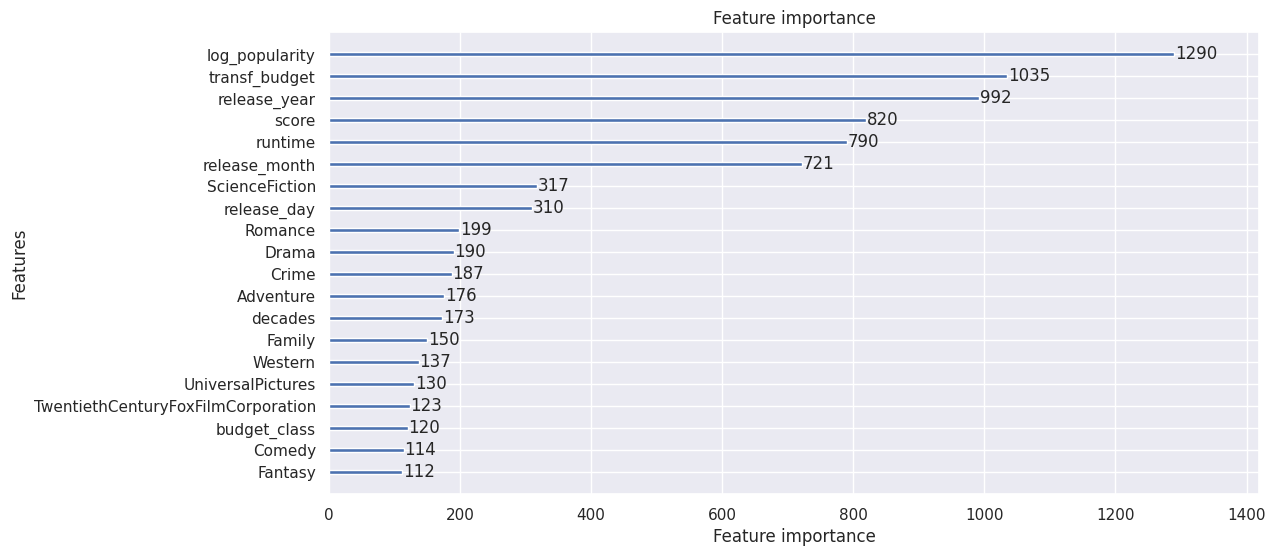

In [208]:
lgb.plot_importance(lgb_model,max_num_features=20)
plt.show()

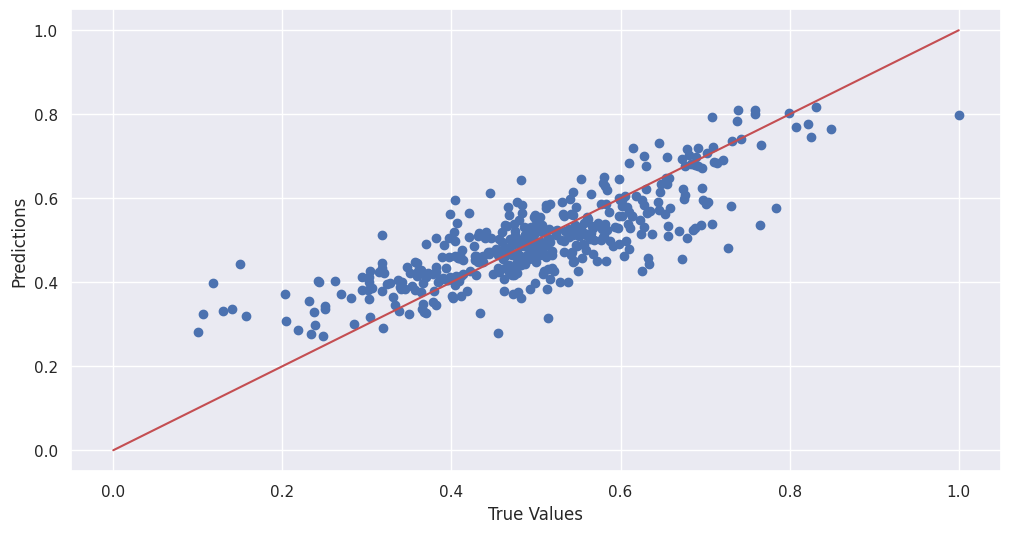

In [209]:
plt.scatter(y_valid, y_pred)
tmp = [min(np.concatenate((y_train,y_valid))),
       max(np.concatenate((y_train,y_valid)))]
plt.plot(tmp,tmp,'r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

## Score ##

Convert categorical features to a list of binary

In [210]:
def binary(genre_list):
    binaryList = []
    
    for genre in genres:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [211]:
full_df['genres_bin'] = full_df['genres'].apply(lambda x: binary(x))
full_df['genres_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

In [212]:
for i,j in zip(full_df['actors'],full_df.index):
    list2=[]
    list2=i[:4]
    full_df.loc[j,'actors']=str(list2)
full_df['actors']=full_df['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['actors']=full_df['actors'].str.split(',')
for i,j in zip(full_df['actors'],full_df.index):
    list2=[]
    list2=i
    list2.sort()
    full_df.loc[j,'actors']=str(list2)
full_df['actors']=full_df['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['actors']=full_df['actors'].str.split(',')

In [213]:
full_df['actors'].head(3)

0    [SamWorthington, SigourneyWeaver, StephenLang,...
1    [JohnnyDepp, KeiraKnightley, OrlandoBloom, Ste...
2    [ChristophWaltz, DanielCraig, LéaSeydoux, Ralp...
Name: actors, dtype: object

In [214]:
actor_list=[]
for row in full_df.index:
    _actors = full_df.loc[row,'actors']
    for g in _actors:
        if g not in actor_list:
            actor_list.append(g)


def binary(cast_list):
    binaryList = []
    
    for genre in actor_list:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [215]:
full_df['actors_bin'] = full_df['actors'].apply(lambda x: binary(x))
full_df['actors_bin'].head(3)


0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...
Name: actors_bin, dtype: object

In [216]:
for i,j in zip(full_df['director'],full_df.index):
    list2=[]
    list2=i[:4]
    full_df.loc[j,'director']=str(list2)
full_df['director']=full_df['director'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['director']=full_df['director'].str.split(',')
for i,j in zip(full_df['director'],full_df.index):
    list2=[]
    list2=i
    list2.sort()
    full_df.loc[j,'director']=str(list2)
full_df['director']=full_df['director'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['director']=full_df['director'].str.split(',')

In [217]:
director_list=[]
for row in full_df.index:
    _actors = full_df.loc[row,'director']
    for g in _actors:
        if g not in director_list:
            director_list.append(g)

def binary(directors):
    binaryList = []
    
    for direct in director_list:
        if direct in directors:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [218]:
full_df['director_bin'] = full_df['director'].apply(lambda x: binary(x))
full_df['director_bin'].head(3)

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: director_bin, dtype: object

In [219]:
full_df['keywords'] = full_df['keywords'].astype(str)

full_df['keywords']=full_df['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
full_df['keywords']=full_df['keywords'].str.split(',')
for i,j in zip(full_df['keywords'],full_df.index):
    list2=[]
    list2=i[:4]
    full_df.loc[j,'keywords']=str(list2)
full_df['keywords']=full_df['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['keywords']=full_df['keywords'].str.split(',')
for i,j in zip(full_df['keywords'],full_df.index):
    list2=[]
    list2=i
    list2.sort()
    full_df.loc[j,'keywords']=str(list2)
full_df['keywords']=full_df['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['keywords']=full_df['keywords'].str.split(',')

In [220]:
words_list = []
for index, row in full_df.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

In [221]:
def binary(words):
    binaryList = []
    
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [222]:
full_df['words_bin'] = full_df['keywords'].apply(lambda x: binary(x))
full_df['words_bin'].head(3)

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...
Name: words_bin, dtype: object

In [223]:
full_df = full_df[(full_df['vote_average']!=0)] #removing the movies with 0 score and without drector names 
full_df = full_df[full_df['director']!='']

In [224]:
new_id = list(range(0,full_df.shape[0]))
full_df['new_id']=new_id
full_df=full_df[['original_title','genres','vote_average','score','genres_bin','actors_bin','new_id','director','director_bin','words_bin']]
full_df.head()

,original_title,genres,vote_average,score,genres_bin,actors_bin,new_id,director,director_bin,words_bin
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",7.2,7.178300,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,[Jame],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",6.9,6.859802,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,[Gore],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectre,"[Action, Adventure, Crime]",6.3,6.289626,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ...",2,[Sam],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ..."
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,7.561937,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",3,[Chri],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
4,John Carter,"[Action, Adventure, Science Fiction]",6.1,6.099331,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,[Andr],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [225]:
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = full_df.iloc[movieId1]
    b = full_df.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['actors_bin']
    scoreB = b['actors_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    return genreDistance + directDistance + scoreDistance

In [226]:
import operator

def score_prediction(name):
    new_movie=full_df[full_df['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in full_df.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgScore = 0
    neighbors = getNeighbors(new_movie, K)

    
    for neighbor in neighbors:
        avgScore = avgScore+full_df.iloc[neighbor[0]][2]  
    
    print('\n')
    avgScore = avgScore/K
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgScore))
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['score']))

In [227]:
score_prediction('Green')

Selected Movie:  Green Lantern


The predicted rating for Green Lantern is: 6.890000
The actual rating for Green Lantern is 5.186089


## Reccomendation System (Overview,Title) ##

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [229]:
tfidf = TfidfVectorizer(stop_words="english")
recommend_df['overview'] = recommend_df['overview'].fillna('')
tfidf_matr = tfidf.fit_transform(recommend_df['overview'])

In [230]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matr,tfidf_matr)

In [231]:
indices = pd.Series(recommend_df.index, index=recommend_df['original_title']).drop_duplicates()

In [232]:
#Recommendation using cosine similarity
def get_recommendations(title, cosine_similarity=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_similarity[idx]))
    #print(sim_scores)
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #print(sim_scores)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return recommend_df['original_title'].iloc[movie_indices]


In [233]:
get_recommendations('Tangled')

38                               TRON: Legacy
310     The Lord of the Rings: The Two Towers
1122                                   Stolen
244                                 Allegiant
1129                        Snakes on a Plane
823                             Your Highness
460                           Despicable Me 2
377                          Last Action Hero
1493                          The World's End
874                                  Anaconda
Name: original_title, dtype: object

## Reccomendation System (Keywords,Actors,Directors,Genres)

In [234]:
from sklearn.feature_extraction.text import CountVectorizer

In [235]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [236]:
# Apply clean_data function to your features.
features = ['actors', 'keywords', 'director', 'genres']


for feature in features:
    recommend_df[feature] = recommend_df[feature].apply(clean_data)

In [237]:
#We create a soup of metadata that will be feed to our Count Vectorizer
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actors']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
recommend_df['soup'] = recommend_df.apply(create_soup, axis=1)

In [238]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(recommend_df['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of our main DataFrame and construct reverse mapping as before
recommend_df = recommend_df.reset_index()
indices = pd.Series(recommend_df.index, index=recommend_df['original_title'])

In [239]:
get_recommendations("Tangled", cosine_sim2)

1244                      Aladdin
489                    Titan A.E.
256     The Princess and the Frog
695                    Pocahontas
1466         Return to Never Land
365                     Enchanted
900                     Pinocchio
242                    The Smurfs
223                    The Croods
336     Atlantis: The Lost Empire
Name: original_title, dtype: object